Lungs Cancer ? 

Problem Satement 

About Data Sets 

Aims and Objective 

In [1]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#Sklearn -libraries 
from sklearn.model_selection import train_test_split
#To balance datasets 
from sklearn.utils import class_weight
#Open CV
import cv2
#Tensorflow and keras Library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
import warnings
warnings.filterwarnings('ignore')

In [2]:
bengin_path = r'./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Bengin cases'
malignant_path = r'./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Malignant cases'
normal_path = r'./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Normal cases'

img_classes = ["Bengin cases", "Malignant cases", "Normal cases"] # Categories 
path_list = [bengin_path, malignant_path, normal_path]

In [3]:
img_path = []
class_labels = []
for i, dir_list in enumerate(path_list):
    name_img = os.listdir(dir_list)
    for name_file in name_img:
        img = os.path.join(dir_list,name_file)
        img_path.append(img)
        class_labels.append(img_classes[i])

df = pd.DataFrame({"img_path" : img_path,
                  "label" : class_labels})

df.head()


,img_path,label
0,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases
1,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases
2,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases
3,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases
4,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases


In [4]:
df.describe()

,img_path,label
count,1933,1933
unique,1933,3
top,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Malignant cases
freq,1,1050


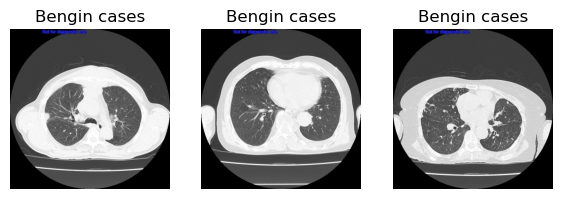

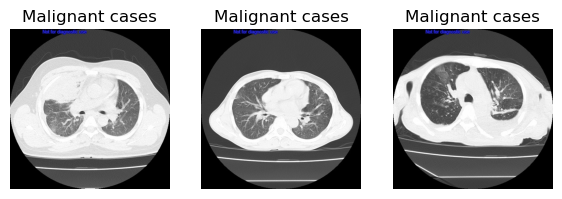

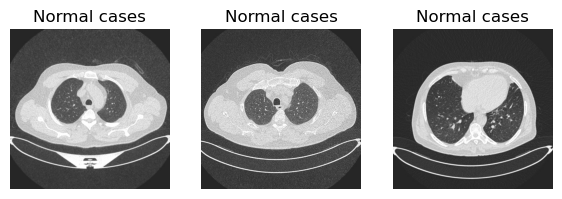

In [5]:
for category, group in df.groupby("label"):
    fig, ax = plt.subplots(1,3, figsize = (7,7))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(3).iterrows()):
        img = cv2.imread(r.img_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(r.label)
    plt.show()

#### Exploratory Data Analysis 

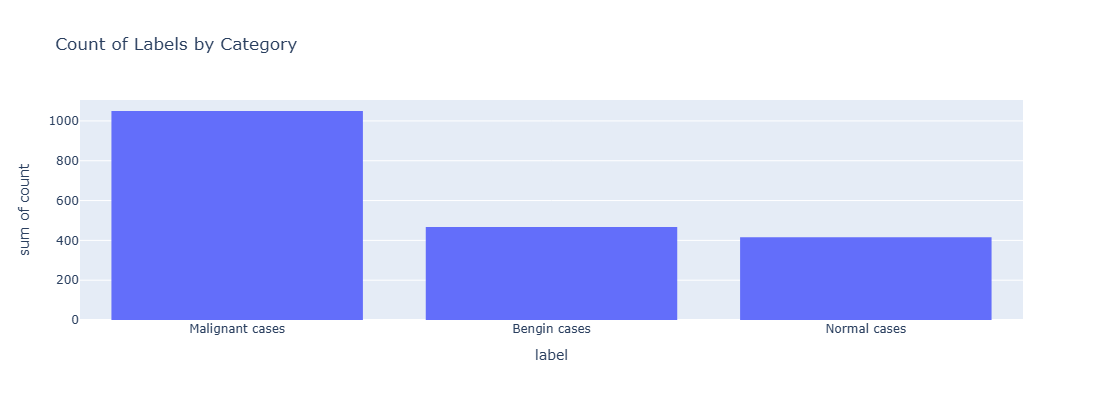

In [6]:
countData = df["label"].value_counts().reset_index()
fig = px.histogram(data_frame = countData, x = "label", y = "count", width=600,
    height=400,
    title="Count of Labels by Category")
fig.show()

#### Analyzing the Image properties 

In [7]:
sizes = []
resolutions = []
color_distributions = []

for img_path in df ["img_path"]:
    # load image 
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #code to get image size
    size = os.path.getsize(img_path)
    sizes.append(size)
    #Extract the resolutions of images
    resolution = img.shape[:2]
    resolutions.append(resolution)
    #Extract color distribution
    mean_color_distributions = np.bincount(img.flatten(), minlength= 256)
    color_distributions.append(mean_color_distributions)
sizes = np.array(sizes)
resolutions = np.array(resolutions)
color_distributions = np.array(color_distributions)

#### Distributions Size of image

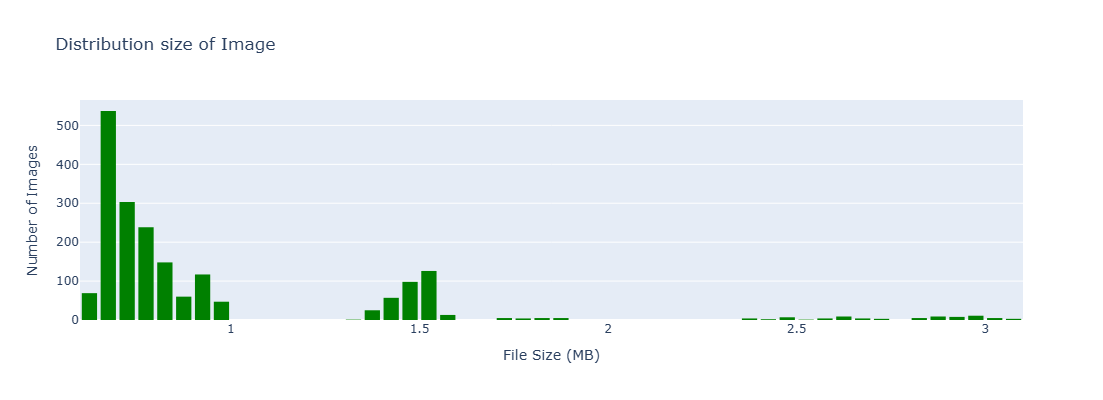

In [8]:
#Image sizes in MB
sizes_MB = []
for img_path in df["img_path"]:
    #code to load image
    img = cv2.imread(img_path)
    #code to get imge size 
    size = os.path.getsize(img_path)
    sizes_MB.append(size/1_00_000)

fig = px.histogram(x=sizes_MB, nbins = 50, title = "Distribution size of Image", width=600,
    height=400)
fig.update_layout(xaxis_title = "File Size (MB)",
                  yaxis_title = "Number of Images",
                  showlegend = False,
                  bargap = 0.1,
                  bargroupgap = 0.1)
fig.update_traces(marker = dict(color="green"))
fig.show()

#### Distributions of image Resulations 

In [9]:
fig = px.scatter(x = resolutions[:,0],
                 y = resolutions[:,1], 
                 title = "Distribution of Image Resolution", height= 400, width= 600)
fig.update_layout(
    xaxis_title = "Width (Pixel)",
    yaxis_title = "Height (Pixel)",
    showlegend = False,
    hovermode = "closest"
)
fig.update_traces(marker = dict(color="red"))
fig.show()

### Mean Color Distributins 

In [10]:
import plotly.graph_objects as go
mean_color_distributions = np.mean(color_distributions, axis = 0)
fig = go.Figure(
    go.Bar(x = np.arange(256), y = mean_color_distributions, name = "Mean Color Distributions"
))
fig.update_layout(
    title = "Mean Color Distribution",
    xaxis_title = "Color Values",
    yaxis_title = "Number of Pixel"
)
fig.show()

#### Train & test 

In [11]:
train_ratio = 0.70
test_ratio = 0.15
val_ratio = 0.15

df_train, df_test_val = train_test_split(df, train_size = train_ratio, random_state = 42)
df_test, df_val = train_test_split(df_test_val, train_size = test_ratio/(test_ratio + val_ratio), random_state = 42)

print(f"Train shape = {df_train.shape}")
print(f"Test shape = {df_test.shape}")
print(f"Validation shape = {df_val.shape}")

Train shape = (1353, 2)
Test shape = (290, 2)
Validation shape = (290, 2)


#### DeNoise image using median blur

In [12]:
def preprocessing_denoise(img):
    denoise_img = cv2.medianBlur(img, 1)
    denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2RGB)
    return denoise_img

#### Data Agrumendations using ImageDataGenerator


In [13]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

image_size = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32

TRAIN_DATAGEN = ImageDataGenerator(rescale = 1./255.,
                                   preprocessing_function = preprocessing_denoise,
                                  rotation_range = 15,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  shear_range = 0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  )


TEST_DATAGEN = ImageDataGenerator(rescale = 1./255.)

#for training image 
train_generator = TRAIN_DATAGEN.flow_from_dataframe(
    df_train,
    x_col = "img_path",
    y_col = "label",
    traget_size = image_size,
    batch_size = batch_size,
    color_mode = 'rgb', 
    class_mode = "categorical",
    shuffle = True
)

# for testing image 
test_generator = TEST_DATAGEN.flow_from_dataframe(
    df_test,
    x_col = "img_path",
    y_col = "label",
    traget_size = image_size,
    batch_size = batch_size,
    color_mode = 'rgb', 
    class_mode = "categorical",
    shuffle = True
)

val_generator = TEST_DATAGEN.flow_from_dataframe(
    df_val,
    x_col = "img_path",
    y_col = "label",
    traget_size = image_size,
    batch_size = batch_size,
    color_mode = 'rgb', 
    class_mode = "categorical",
    shuffle = True
)


Found 1353 validated image filenames belonging to 3 classes.
Found 290 validated image filenames belonging to 3 classes.
Found 290 validated image filenames belonging to 3 classes.


#### Class weight 

In [14]:
#The datasets is hightly imblace so we used Class weight for balancing the datasets 

#image categories
classes = list(train_generator.class_indices.keys())

class_weights = class_weight.compute_class_weight(
           class_weight = 'balanced',
            classes = np.unique(train_generator.classes),
            y = train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

#classes = list(train_generator.class_indices.keys())
for idx, weight, in train_class_weights.items():
    class_name = classes[idx]
    print(f"{class_name} : {weight}")

Bengin cases : 1.3666666666666667
Malignant cases : 0.6186556927297668
Normal cases : 1.534013605442177


#### Model  Implementations #3D-CNN Model 

In [15]:

model_2D = Sequential([
    # Conv Block 1
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(256,256, 3)),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Conv Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Conv Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Conv Block 4
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Conv Block 5
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Conv Block 6
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Global Average Pooling
    GlobalAveragePooling2D(),

    # Fully Connected Layers
    Dense(256, activation='relu'),
    Dropout(0.25),

    Dense(3, activation='softmax')  # Assuming 3 classes
]) 

model_2D.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,215,555 (4.64 MB)

 Trainable params: 1,213,763 (4.63 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [16]:
model_2D.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(learning_rate = 0.0003),
    metrics = ["accuracy"],
)
epochs = 50
history = model_2D.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 32,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min')
                              ],
                   epochs = epochs)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 407s 9s/step - accuracy: 0.6192 - loss: 0.6988 - val_accuracy: 0.2172 - val_loss: 1.7543 - learning_rate: 3.0000e-04
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 366s 8s/step - accuracy: 0.7715 - loss: 0.3819 - val_accuracy: 0.2172 - val_loss: 3.5431 - learning_rate: 3.0000e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 390s 9s/step - accuracy: 0.8151 - loss: 0.2972 - val_accuracy: 0.2172 - val_loss: 5.6409 - learning_rate: 3.0000e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 372s 9s/step - accuracy: 0.8200 - loss: 0.2852 - val_accuracy: 0.2034 - val_loss: 3.8561 - learning_rate: 3.0000e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 339s 8s/step - accuracy: 0.8528 - loss: 0.2755 - val_accuracy: 0.2172 - val_loss: 14.0597 - learning_rate: 3.0000e-04
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 333s 8s/step - accuracy: 0.8693 - loss: 0.2294 - val_accuracy: 0.2172 - val_loss: 8.2432 - learning_rate: 6.0000e-05


##### Training & validation Acuracy loss

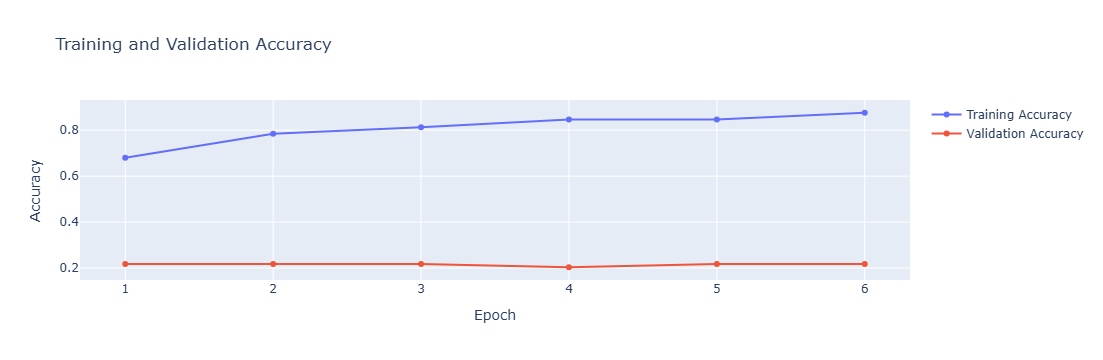

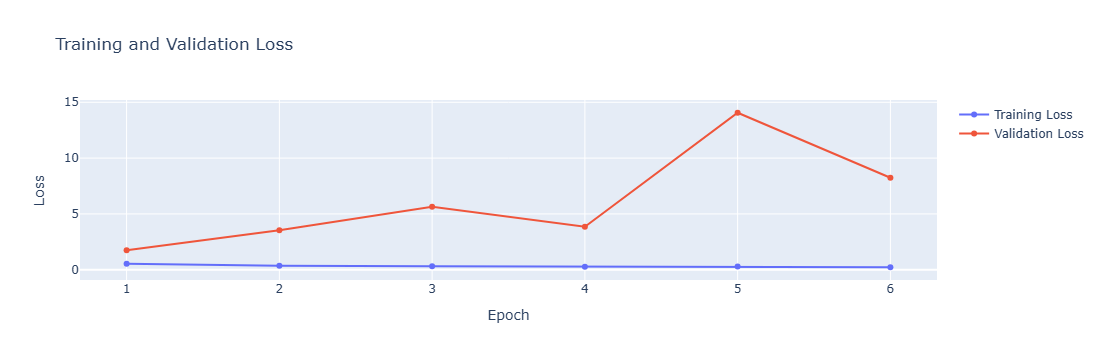

In [17]:
def history_plot(epochs, history):
    fig1 = make_subplots()
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["accuracy"], name = "Training Accuracy"))
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_accuracy"], name = "Validation Accuracy"))
    fig1.update_layout(title = "Training and Validation Accuracy", xaxis_title = "Epoch", yaxis_title = "Accuracy")
    fig1.show()

    fig2 = make_subplots()
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["loss"], name = "Training Loss"))
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_loss"], name = "Validation Loss"))
    fig2.update_layout(title = "Training and Validation Loss", xaxis_title = "Epoch", yaxis_title = "Loss")
    fig2.show()

history_plot(epochs, history)

In [18]:
def evaluate_model(model, test_generator):
    #Calculate test loss and accuracy
    results = model.evaluate(test_generator, verbose = 0)
    print(f"Test Loss = {results[0]}")
    print(f"Test Accuracy = {results[1]}")
evaluate_model(model_2D, test_generator)

Test Loss = 1.7793232202529907
Test Accuracy = 0.20344828069210052


#### Transfer learning for improving Accuray (using Fine tune Model Vgg16 and InceptionsV3)

In [19]:
#Define base_model of InceptionV3
base_model = InceptionV3(input_shape = (256,256,3), include_top = False, weights = "imagenet")
#Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

#Add Custom layers
model_IV3 = Sequential()
model_IV3.add(Input(shape = (256,256, 3)))
model_IV3.add(base_model)
model_IV3.add(GlobalAveragePooling2D())
model_IV3.add(Dense(1024, activation = "relu"))
model_IV3.add(Dropout(0.4))
model_IV3.add(Dense(3, activation = "softmax"))
#Compile and Training the model 
epochs = 50
model_IV3.compile(optimizer = Adam(0.0003),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])
history = model_IV3.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                              ],
                   epochs = epochs)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 260s 6s/step - accuracy: 0.5939 - loss: 0.8159 - val_accuracy: 0.8138 - val_loss: 0.4054 - learning_rate: 3.0000e-04
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - accuracy: 0.7637 - loss: 0.4756 - val_accuracy: 0.6828 - val_loss: 0.6006 - learning_rate: 3.0000e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 214s 5s/step - accuracy: 0.7880 - loss: 0.4025 - val_accuracy: 0.6034 - val_loss: 0.8188 - learning_rate: 3.0000e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step - accuracy: 0.7614 - loss: 0.3855 - val_accuracy: 0.8655 - val_loss: 0.3120 - learning_rate: 6.0000e-05
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - accuracy: 0.8133 - loss: 0.3044 - val_accuracy: 0.8069 - val_loss: 0.3843 - learning_rate: 6.0000e-05
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.8411 - loss: 0.3064 - val_accuracy: 0.7759 - val_loss: 0.4379 - learning_rate: 6.0000e-05
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.8090 

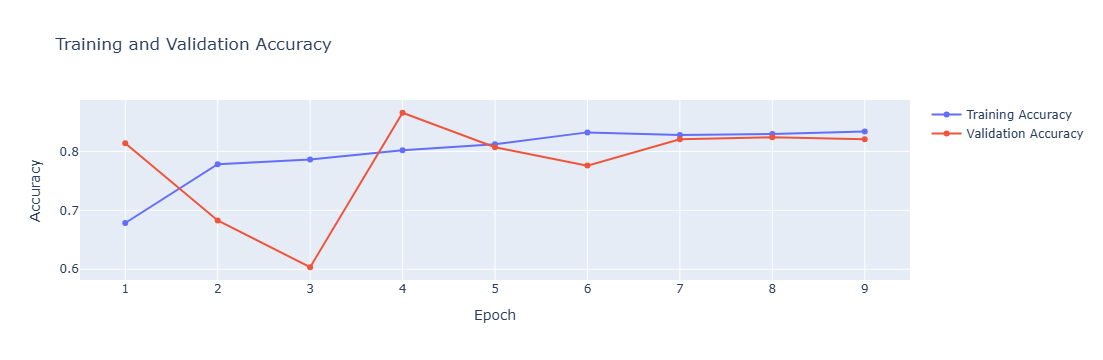

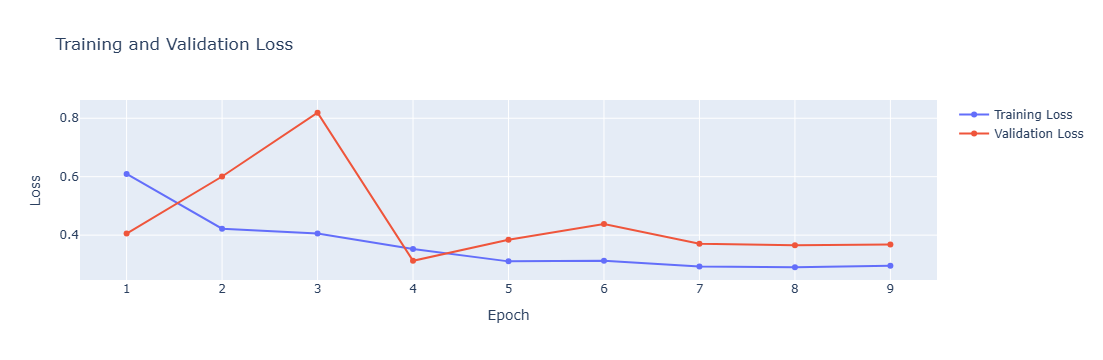

In [20]:
#Plot the graph
history_plot(epochs, history)

In [21]:
evaluate_model(model_IV3, test_generator)

Test Loss = 0.3387872576713562
Test Accuracy = 0.865517258644104


### Fine tune InceptionsV3 Model

In [22]:
# All layers does not freeze
base_model.trainable = True
#Compile the model
model_IV3.compile(optimizer = Adam(0.0001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])
#Training the model
epochs = 50
history = model_IV3.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
                              ],
                   epochs = epochs)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step - accuracy: 0.8081 - loss: 0.3356 - val_accuracy: 0.8379 - val_loss: 0.3342 - learning_rate: 1.0000e-04
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 209s 5s/step - accuracy: 0.8253 - loss: 0.3200 - val_accuracy: 0.7138 - val_loss: 0.5298 - learning_rate: 1.0000e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.8021 - loss: 0.3129 - val_accuracy: 0.7897 - val_loss: 0.3957 - learning_rate: 1.0000e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - accuracy: 0.8263 - loss: 0.3043 - val_accuracy: 0.7931 - val_loss: 0.3981 - learning_rate: 2.0000e-05
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 269s 6s/step - accuracy: 0.8229 - loss: 0.3023 - val_accuracy: 0.7621 - val_loss: 0.4305 - learning_rate: 2.0000e-05
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - accuracy: 0.8397 - loss: 0.2694 - val_accuracy: 0.8138 - val_loss: 0.3735 - learning_rate: 4.0000e-06


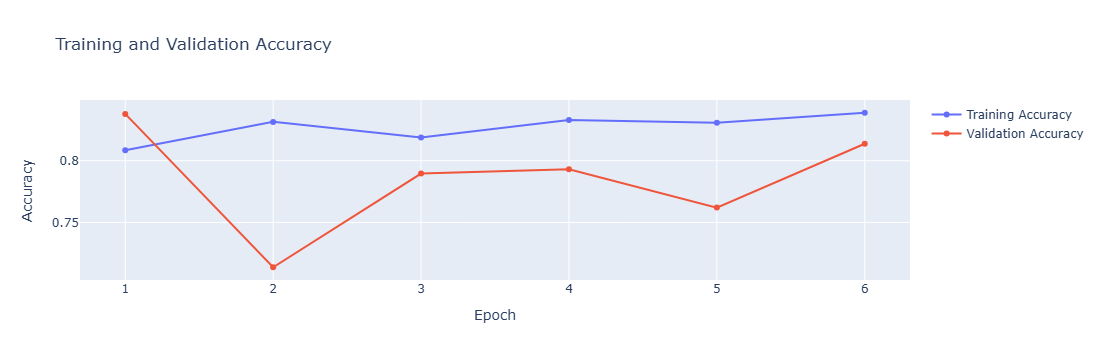

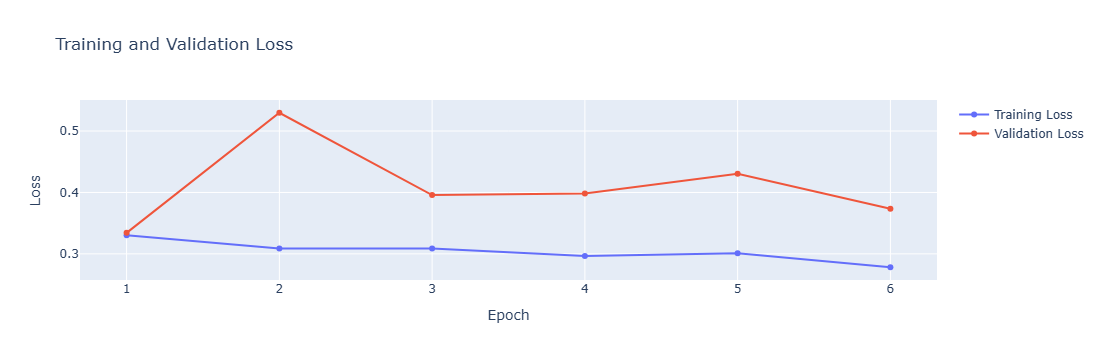

In [23]:
#Plot the graph
history_plot(epochs, history)

In [24]:
evaluate_model(model_IV3, test_generator)

Test Loss = 0.35501089692115784
Test Accuracy = 0.8275862336158752


### Finetune VGG16 Model 

In [25]:
#Define base mode of VGG16
base_model_vgg16 = VGG16(input_shape = (256,256, 3), include_top = False, weights = "imagenet")

#Freeze all layers VGG16 model
for layer in base_model_vgg16.layers:
    layer.trainable = False

#Add custom layers
model_VGG16 = Sequential()
model_VGG16 .add(Input(shape = (256, 256, 3)))
model_VGG16 .add(base_model)
model_VGG16 .add(GlobalAveragePooling2D())
model_VGG16 .add(Dense(1024, activation = "relu"))
model_VGG16 .add(Dropout(0.4))
model_VGG16 .add(Dense(3, activation = "softmax"))

#Compile model
model_VGG16 .compile(optimizer = Adam(0.0003),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

#Training the model
epochs = 50
history = model_VGG16 .fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min') 
                              ],
                   epochs = epochs)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - accuracy: 0.5909 - loss: 0.8642 - val_accuracy: 0.7793 - val_loss: 0.4705 - learning_rate: 3.0000e-04
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 300s 6s/step - accuracy: 0.7969 - loss: 0.4326 - val_accuracy: 0.5586 - val_loss: 1.0340 - learning_rate: 3.0000e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.7779 - loss: 0.3844 - val_accuracy: 0.8034 - val_loss: 0.4017 - learning_rate: 3.0000e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.7851 - loss: 0.3547 - val_accuracy: 0.8034 - val_loss: 0.3825 - learning_rate: 3.0000e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - accuracy: 0.8047 - loss: 0.3621 - val_accuracy: 0.8483 - val_loss: 0.3214 - learning_rate: 3.0000e-04
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - accuracy: 0.8368 - loss: 0.3027 - val_accuracy: 0.8069 - val_loss: 0.3864 - learning_rate: 3.0000e-04
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 286s 7s/step - accuracy: 0.8420 

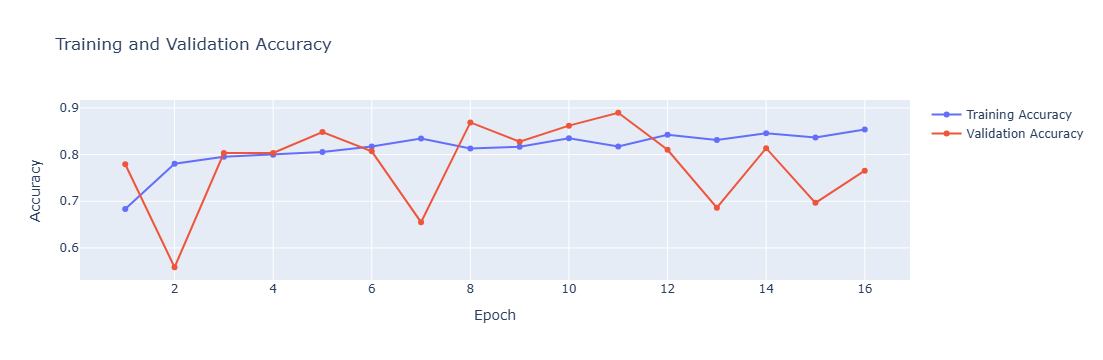

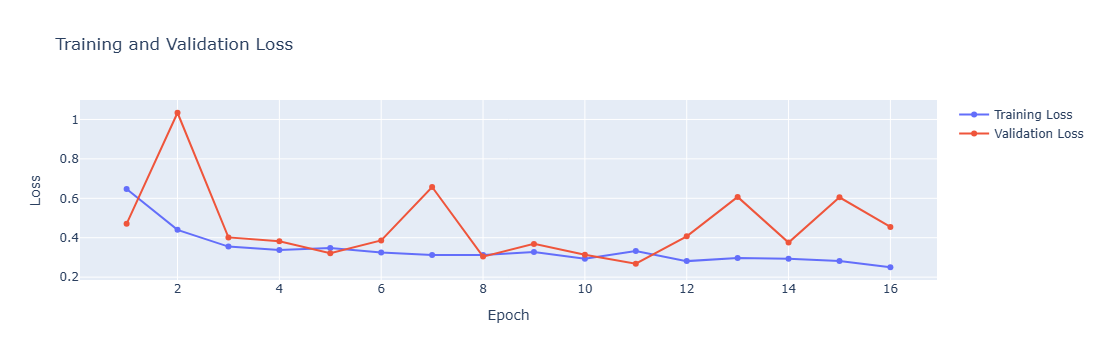

In [26]:
history_plot(epochs, history)

In [27]:
evaluate_model(model_VGG16 ,test_generator)

Test Loss = 0.3122091293334961
Test Accuracy = 0.8758620619773865


In [28]:
#Set the training layer jus block_conv1
base_model_vgg16.trainable = True
set_trainable = False
for layer in base_model_vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

#Compile the model
model_VGG16 .compile(optimizer = Adam(0.0001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])   
#Training the model
epochs = 50
history = model_VGG16.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), 
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min') 
                              ],
                   epochs = epochs)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - accuracy: 0.8307 - loss: 0.2897 - val_accuracy: 0.7310 - val_loss: 0.5026 - learning_rate: 1.0000e-04
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - accuracy: 0.8375 - loss: 0.2797 - val_accuracy: 0.7759 - val_loss: 0.4361 - learning_rate: 1.0000e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - accuracy: 0.8633 - loss: 0.2486 - val_accuracy: 0.8034 - val_loss: 0.4015 - learning_rate: 1.0000e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 209s 5s/step - accuracy: 0.8396 - loss: 0.2711 - val_accuracy: 0.8483 - val_loss: 0.3214 - learning_rate: 1.0000e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.8540 - loss: 0.2539 - val_accuracy: 0.7690 - val_loss: 0.4890 - learning_rate: 1.0000e-04
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.8496 - loss: 0.2679 - val_accuracy: 0.8172 - val_loss: 0.3835 - learning_rate: 1.0000e-04
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.8726 

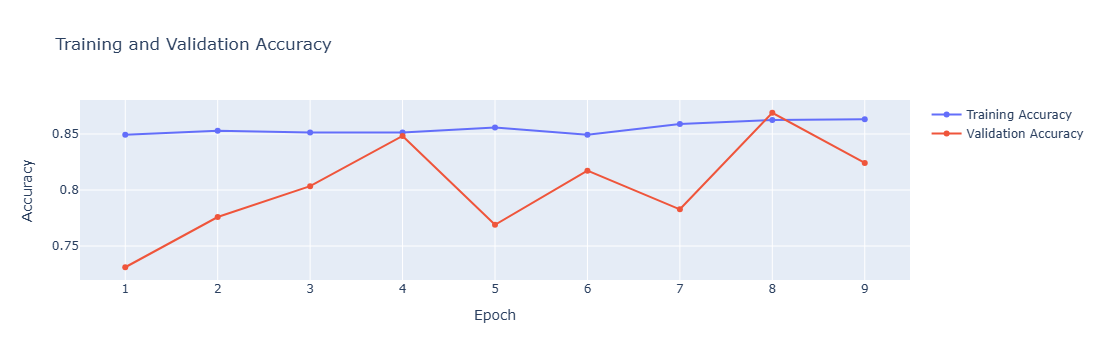

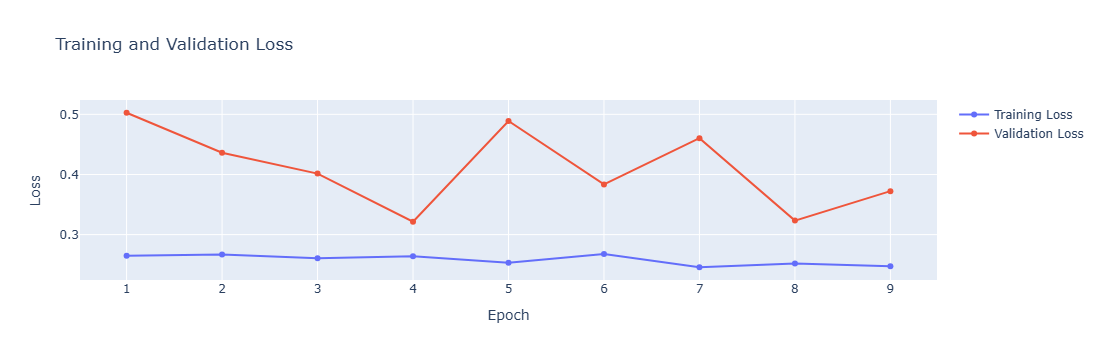

In [29]:
history_plot(epochs,history)

In [30]:
evaluate_model(model_VGG16, test_generator)

Test Loss = 0.33947649598121643
Test Accuracy = 0.834482729434967


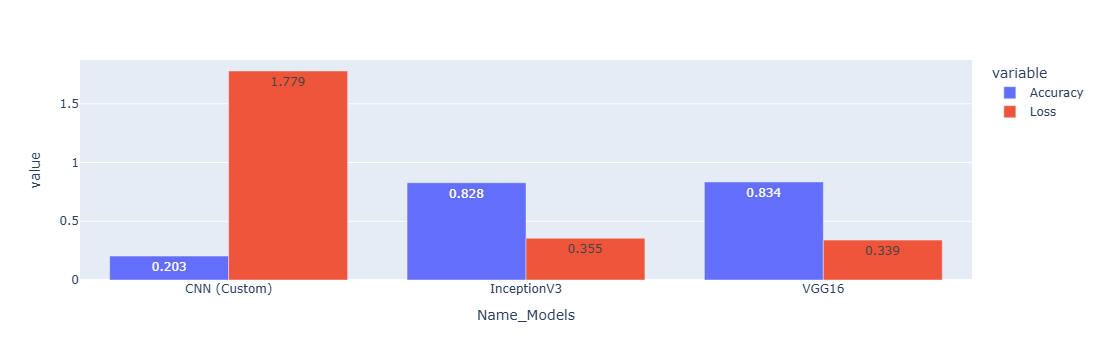

In [31]:
#Results of the model
models = [model_2D, model_IV3, model_VGG16 ]
loss = []
accuracy = []
for model in models:
    results = model.evaluate(test_generator, verbose = 0)
    loss.append(results[0])
    accuracy.append(results[1])

name_models = ["CNN (Custom)", "InceptionV3", "VGG16"]
df_loss_acc = pd.DataFrame(data = {"Name_Models" : name_models,
                                  "Loss" : loss,
                                  "Accuracy" : accuracy})

fig = px.bar(data_frame = df_loss_acc, x = "Name_Models", y = ["Accuracy", "Loss"],
            barmode = "group",
            text_auto = ".3f")
fig.show()